In [17]:
import video_processing
import torch

In [18]:
from video_processing.prepare_data import extract_frames, prepare_train_data, prepare_train_data_diffusion

In [19]:
device = torch.device('cuda') if  torch.cuda.is_available() else torch.device('cpu')

In [20]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=64,
    in_channels=3 + 5*3,  # Noisy image (3) + condition (5*3)
    out_channels=3,       # Predict noise
    layers_per_block=2,
    block_out_channels=(128, 256, 512, 512),
    down_block_types=(
        "DownBlock2D", "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"
    ),
)
model.to(device)

UNet2DModel(
  (conv_in): Conv2d(18, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 128, eps=1e-05, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(1

In [21]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear"
)

In [22]:
from torch.utils.data import DataLoader, TensorDataset
# 1. Extract and prepare data
video_path="/Users/chrishon/capstone-camera-traps/resources/videos/FH102_02 (1).avi"
frames = extract_frames(video_path)

In [ ]:
frames = frames[:1000]

In [24]:
len(frames)

100

In [25]:

X_condition, y_target = prepare_train_data_diffusion(frames, sequence_length=5)

# 2. Create dataloader
X_tensor = torch.tensor(X_condition, dtype=torch.float32)
y_tensor = torch.tensor(y_target, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# 3. Verify shapes
sample_batch = next(iter(train_loader))
condition_batch, target_batch = sample_batch
print(f"Condition shape: {condition_batch.shape}")  # Should be (batch, 15, 64, 64)
print(f"Target shape: {target_batch.shape}")        # Should be (batch, 3, 64, 64)

Condition shape: torch.Size([8, 15, 64, 64])
Target shape: torch.Size([8, 3, 64, 64])


In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 1
for epoch in range(num_epochs):
    i = 1
    for batch_condition, batch_target in train_loader:
        print(i)
        i += 1
        batch_condition = batch_condition.to(device)
        batch_target = batch_target.to(device)
        
        # Sample noise and timesteps
        noise = torch.randn_like(batch_target)
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, 
                                 (batch_target.shape[0],), device=device)
        
        # Add noise to targets
        noisy_images = noise_scheduler.add_noise(batch_target, noise, timesteps)
        
        # Combine with condition and predict noise
        model_input = torch.cat([noisy_images, batch_condition], dim=1)
        noise_pred = model(model_input, timesteps).sample
        
        # Compute loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)
        
        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

1


/opt/homebrew/anaconda3/envs/capstone/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


2
3
4
5
6
7
8
9
10
11
12
Epoch 1, Loss: 0.3709


In [27]:
def predict_next_frame(model, condition, scheduler, device):
    model.eval()
    with torch.no_grad():
        # Initial noise
        sample = torch.randn((1, 3, 64, 64), device=device)
        condition = condition.unsqueeze(0).to(device)
        
        # Denoising loop
        for t in scheduler.timesteps:
            model_input = torch.cat([sample, condition], dim=1)
            noise_pred = model(model_input, t).sample
            sample = scheduler.step(noise_pred, t, sample).prev_sample
        
        # Denormalize and format
        predicted_frame = sample.squeeze().cpu().numpy()
        predicted_frame = (predicted_frame + 1) / 2  # [0, 1]
        predicted_frame = np.transpose(predicted_frame, (1, 2, 0))
        return predicted_frame

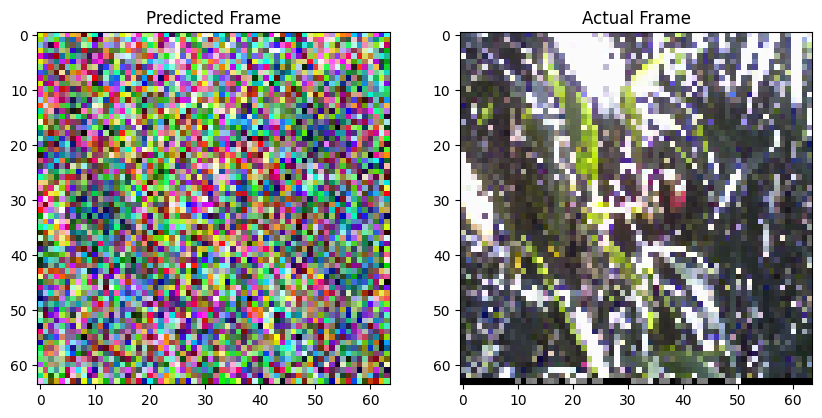

In [28]:
import matplotlib.pyplot as plt
import numpy as np
# Prepare test data
X_condition_test, y_test = X_condition, y_target
# X_condition_test, y_test = prepare_train_data(test_frames)

# Select sample
sample_idx = 3
condition_sample = torch.tensor(X_condition_test[sample_idx], dtype=torch.float32)
actual_frame = (y_test[sample_idx].transpose(1, 2, 0) + 1) / 2  # To HWC and [0,1]

# Generate prediction
predicted_frame = predict_next_frame(model, condition_sample, noise_scheduler, device)

# Plot
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(predicted_frame)
plt.title("Predicted Frame")
plt.subplot(1, 2, 2)
plt.imshow(actual_frame)
plt.title("Actual Frame")
plt.show()

In [29]:
from video_processing.post_processing import frame_analysis, visualize_comparison, temporal_analysis

In [30]:
analysis_results = frame_analysis(predicted_frame, actual_frame)
analysis_results

{'mean_absolute_error': 0.29299194,
 'max_absolute_error': 1.0,
 'ssim': 0.13529588,
 'patch_diff': array([0.30678105, 0.31637338, 0.31070024, 0.30755815, 0.27236333,
        0.29704845, 0.29426208, 0.2571458 , 0.28648403, 0.27179128,
        0.296087  , 0.2823671 , 0.29564178, 0.30812573, 0.2987691 ,
        0.28637227], dtype=float32)}

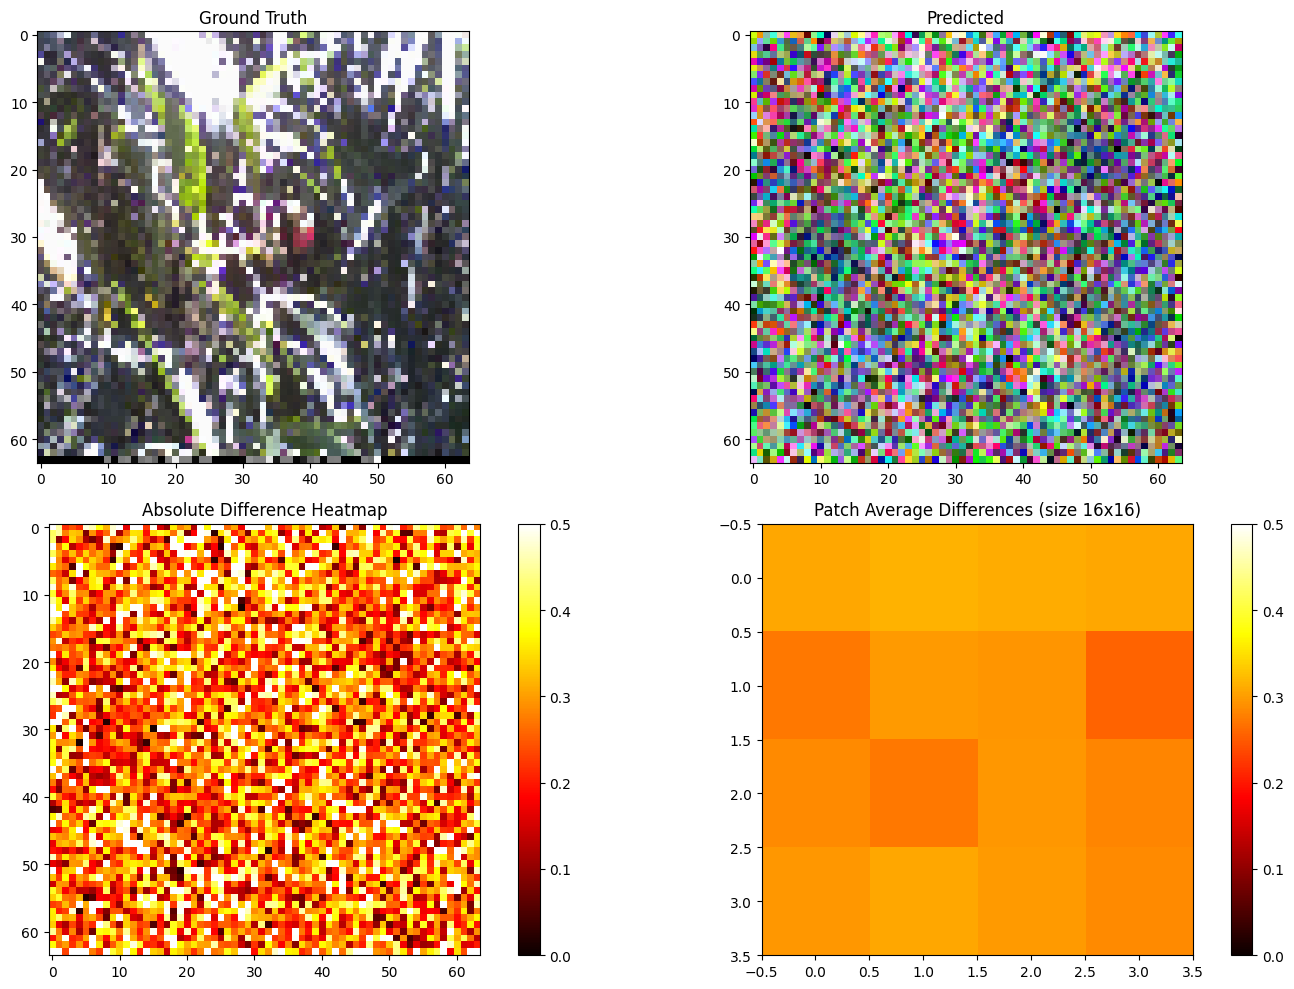

In [31]:
visualize_comparison(predicted_frame, actual_frame)